#**PROYEK AKHIR KELAS MACHINE LEARNING TERAPAN** - **FARISCHA MAKAY** 

##**PENDAHULUAN**
Proyek ini merupakan sistem rekomendasi aplikasi bagi pengguna ios yakni Apple IOS app store dengan menggunakan teknik content-based filtering. 

## **IMPOR MODUL YANG DIGUNAKAN**

In [1]:
# Memasang modul plotly & scikit-learn terbaru
!pip install -U plotly
!pip install -U scikit-learn

     |████████████████████████████████| 25.3 MB 68 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
# Untuk pengolahan data
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import random
from plotly import tools

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from plotly.subplots import make_subplots

# Untuk visualisasi data
import plotly.express as px
from plotly.offline import iplot
import missingno as msno
import matplotlib.pyplot as plt
import plotly.graph_objs as go


# Untuk pembuatan sistem rekomendasi 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Untuk evaluasi sistem rekomendasi
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

## **MENGAMBIL DATA DARI KAGGLE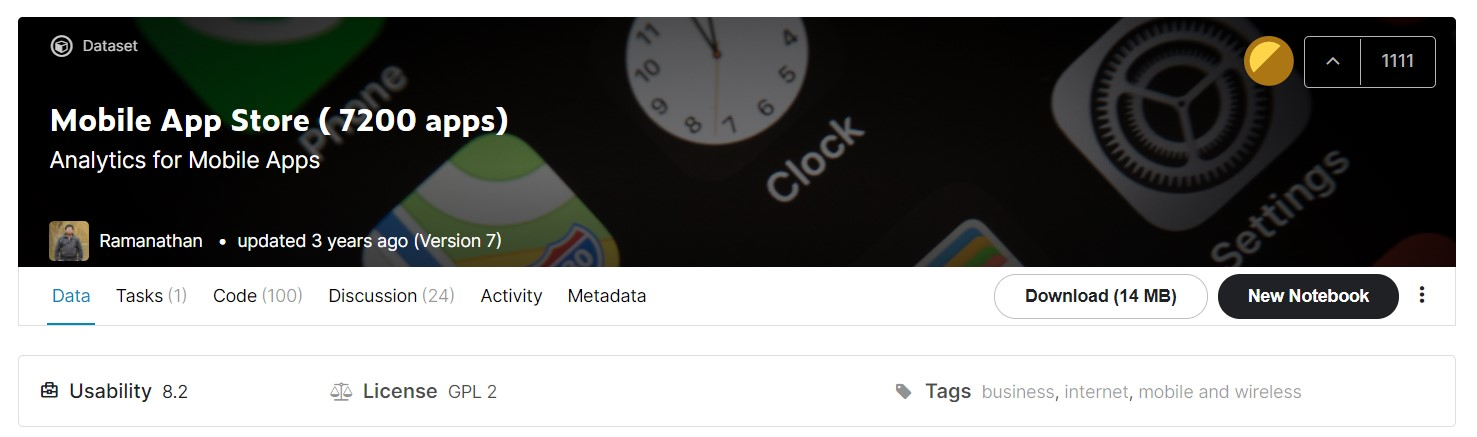**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [5]:
%cd /content/gdrive/MyDrive/kaggle_dataset

/content/gdrive/MyDrive/kaggle_dataset


In [6]:
!kaggle datasets download -d ramamet4/app-store-apple-data-set-10k-apps

  0% 0.00/5.63M [00:00<?, ?B/s]
100% 5.63M/5.63M [00:00<00:00, 52.1MB/s]


In [7]:
!mkdir app-store-apple-data-set-10k-apps
!mv app-store-apple-data-set-10k-apps.zip app-store-apple-data-set-10k-apps

mkdir: cannot create directory ‘app-store-apple-data-set-10k-apps’: File exists


In [8]:
%cd app-store-apple-data-set-10k-apps

/content/gdrive/MyDrive/kaggle_dataset/app-store-apple-data-set-10k-apps


In [9]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip -qq app-store-apple-data-set-10k-apps.zip -d aplikasi
!ls aplikasi

replace aplikasi/AppleStore.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
AppleStore.csv	appleStore_description.csv


## **DATA UNDERSTANDING**

In [10]:
df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/app-store-apple-data-set-10k-apps/aplikasi/AppleStore.csv" ,sep =',' , encoding = 'utf8' )

In [11]:
#load_data
df.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [12]:
# Memuat informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7197 non-null   int64  
 1   id                7197 non-null   int64  
 2   track_name        7197 non-null   object 
 3   size_bytes        7197 non-null   int64  
 4   currency          7197 non-null   object 
 5   price             7197 non-null   float64
 6   rating_count_tot  7197 non-null   int64  
 7   rating_count_ver  7197 non-null   int64  
 8   user_rating       7197 non-null   float64
 9   user_rating_ver   7197 non-null   float64
 10  ver               7197 non-null   object 
 11  cont_rating       7197 non-null   object 
 12  prime_genre       7197 non-null   object 
 13  sup_devices.num   7197 non-null   int64  
 14  ipadSc_urls.num   7197 non-null   int64  
 15  lang.num          7197 non-null   int64  
 16  vpp_lic           7197 non-null   int64  


In [13]:
# Menghitung jumlah data kosong pada setiap kolom
df.isna().sum()


Unnamed: 0          0
id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64

##**DATA PREPARATION**

###**Memeriksa apakah dataset memiliki nilai null atau kosong atau tidak**


In [14]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(df)

,Total,Percent
vpp_lic,0,0.0
rating_count_ver,0,0.0
id,0,0.0
track_name,0,0.0
size_bytes,0,0.0
currency,0,0.0
price,0,0.0
rating_count_tot,0,0.0
user_rating,0,0.0
lang.num,0,0.0


Hasil yang ditemukan, data bersih dari nilai null atau kosong.

### **Memeriksa data duplikasi**

In [15]:
# Melihat jumlah data duplikasi
df.duplicated().sum()

0

### **Data Cleaning**

Menghapus kolom yang tidak diperlukan

In [16]:
# Menghapus kolom Unnamed : 0, vpp_lic, currency
df = df.drop(['Unnamed: 0','vpp_lic','currency'],axis=1)
df.head()

,id,track_name,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num
0,281656475,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10
1,281796108,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9
4,282935706,Bible,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45


Mengganti nama seperti cont_rating menjadi content_rate agar lebih mudah dimengerti

In [17]:
df.rename(columns={'track_name':'app_name','cont_rating':'content_rate',
                        'prime_genre':'genre','rating_count_tot':'versions_rating',
                       'rating_count_ver':'version_rating','sup_devices.num':'supp_devices','ipadSc_urls.num':'screen_shots_displayed',
                       'lang.num':'supp_lang_num'},inplace=True)
df.head()

,id,app_name,size_bytes,price,versions_rating,version_rating,user_rating,user_rating_ver,ver,content_rate,genre,supp_devices,screen_shots_displayed,supp_lang_num
0,281656475,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10
1,281796108,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9
4,282935706,Bible,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45


Agar lebih rapih di lihat, untuk kolom yang berisi string kita atur posisinya dibagian awal dan yang berupa numerik di belakang

In [18]:
df=df.loc[:,['app_name','genre','user_rating_ver','version_rating','price','supp_devices','screen_shots_displayed','size_bytes']]
df.head()

,app_name,genre,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes
0,PAC-MAN Premium,Games,4.5,26,3.99,38,5,100788224
1,Evernote - stay organized,Productivity,3.5,26,0.00,37,5,158578688
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",Weather,4.5,2822,0.00,37,5,100524032
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",Shopping,4.5,649,0.00,37,5,128512000
4,Bible,Reference,5.0,5320,0.00,37,5,92774400


Sekarang data sudah baik dan siap untuk melakukan visualisasi

In [19]:
df = df.sort_values(by=['user_rating_ver','version_rating'],ascending=False)
df.head()

,app_name,genre,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes
498,Infinity Blade,Games,5.0,177050,0.99,43,5,624107810
545,"Zappos: shop shoes & clothes, fast free shipping",Shopping,5.0,39452,0.00,37,4,70325248
479,shopkick - Shopping Rewards & Discounts,Shopping,5.0,29363,0.00,37,4,74822656
3616,Browser and File Manager for Documents,Utilities,5.0,27213,0.00,37,4,42198016
2989,The Room Three,Games,5.0,21769,4.99,39,5,1005560832


### **Visualisasi data**

Pada bagian ini kita akan mencari tahu bagian gendre yang memiliki rating terbanyak dan juga 

In [20]:
top_rated=df.loc[df['user_rating_ver']==5.0]


In [21]:
paid_apps=top_rated[top_rated['price']>0]
rated_paid_apps=paid_apps.sort_values('version_rating',ascending=False)
top_rated_paid_apps=rated_paid_apps.groupby(by='genre').count()
top_rated_paid_apps=top_rated_paid_apps['app_name']
top_rated_paid_apps

genre
Book                   9
Business              12
Catalogs               1
Education             35
Entertainment         28
Finance                4
Games                217
Health & Fitness      21
Lifestyle              8
Medical                3
Music                 17
Navigation             1
News                   1
Photo & Video         41
Productivity          19
Reference              7
Shopping               1
Social Networking      5
Sports                 9
Travel                10
Utilities             15
Weather                9
Name: app_name, dtype: int64

In [22]:
free_apps=top_rated[top_rated['price']==0.0]
rated_free_apps=free_apps.sort_values('version_rating',ascending=False)
top_rated_free_apps=rated_free_apps.groupby(by='genre').count()
top_rated_free_apps=top_rated_free_apps['app_name']
top_rated_free_apps

genre
Book                   7
Business               2
Catalogs               2
Education             13
Entertainment         26
Finance                8
Food & Drink           8
Games                258
Health & Fitness      19
Lifestyle              6
Medical                4
Music                 10
Navigation             1
News                   8
Photo & Video         36
Productivity          12
Reference              3
Shopping              20
Social Networking     13
Sports                 8
Travel                 7
Utilities             17
Weather                3
Name: app_name, dtype: int64

In [23]:
genre=np.unique(df['genre'])
genre

array(['Book', 'Business', 'Catalogs', 'Education', 'Entertainment',
       'Finance', 'Food & Drink', 'Games', 'Health & Fitness',
       'Lifestyle', 'Medical', 'Music', 'Navigation', 'News',
       'Photo & Video', 'Productivity', 'Reference', 'Shopping',
       'Social Networking', 'Sports', 'Travel', 'Utilities', 'Weather'],
      dtype=object)

In [24]:
frame = {'top_rated_free': top_rated_free_apps,'top_rated_paid':top_rated_paid_apps}

In [25]:
combined=pd.DataFrame(frame,index=genre)

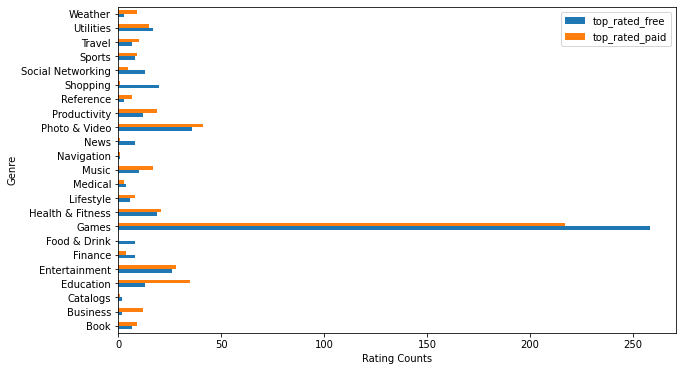

In [26]:
combined.plot(kind='barh',
             figsize=(10,6))
plt.xlabel('Rating Counts')
plt.ylabel('Genre')
plt.show()

Dari visualisasi yang dapat kita lihat diatas, gendre Games merupakan aplikasi yang memiliki rating terbanyak dan juga kita dapat melihat bahwa aplikasi berbayar dan gratis paling banyak pada gendre Games.

In [27]:
df = df.sort_index(ascending=True)
df.head()

,app_name,genre,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes
0,PAC-MAN Premium,Games,4.5,26,3.99,38,5,100788224
1,Evernote - stay organized,Productivity,3.5,26,0.00,37,5,158578688
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",Weather,4.5,2822,0.00,37,5,100524032
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",Shopping,4.5,649,0.00,37,5,128512000
4,Bible,Reference,5.0,5320,0.00,37,5,92774400


In [28]:
# Menyimpan nama-nama aplikasi pada dataframe baru
df_app_name = pd.DataFrame({'app_name':df['app_name']})
df_app_name.head()

,app_name
0,PAC-MAN Premium
1,Evernote - stay organized
2,"WeatherBug - Local Weather, Radar, Maps, Alerts"
3,"eBay: Best App to Buy, Sell, Save! Online Shop..."
4,Bible


In [29]:
# Menggunakan kolom aplikasi sebagai index
df.set_index('app_name',inplace=True)
df.head()

,genre,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes
app_name,,,,,,,
PAC-MAN Premium,Games,4.5,26,3.99,38,5,100788224
Evernote - stay organized,Productivity,3.5,26,0.00,37,5,158578688
"WeatherBug - Local Weather, Radar, Maps, Alerts",Weather,4.5,2822,0.00,37,5,100524032
"eBay: Best App to Buy, Sell, Save! Online Shopping",Shopping,4.5,649,0.00,37,5,128512000
Bible,Reference,5.0,5320,0.00,37,5,92774400


### **Konversi label kategori menjadi one-hot encoding**

In [30]:
# Memilih semua kolom dengan tipe data object
column_object = df.dtypes[df.dtypes == 'object'].keys()
column_object


Index(['genre'], dtype='object')

In [31]:
# Mengkonversi data kategori ke one-hot encoding
one_hot_label = pd.get_dummies(df[column_object])
one_hot_label.head(3)

,genre_Book,genre_Business,genre_Catalogs,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Games,genre_Health & Fitness,genre_Lifestyle,genre_Medical,genre_Music,genre_Navigation,genre_News,genre_Photo & Video,genre_Productivity,genre_Reference,genre_Shopping,genre_Social Networking,genre_Sports,genre_Travel,genre_Utilities,genre_Weather
app_name,,,,,,,,,,,,,,,,,,,,,,,
PAC-MAN Premium,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Evernote - stay organized,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
"WeatherBug - Local Weather, Radar, Maps, Alerts",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [32]:
# Menghapus kolom dengan tipe data object
df.drop(column_object,axis=1,inplace=True)
df.head()

,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes
app_name,,,,,,
PAC-MAN Premium,4.5,26,3.99,38,5,100788224
Evernote - stay organized,3.5,26,0.00,37,5,158578688
"WeatherBug - Local Weather, Radar, Maps, Alerts",4.5,2822,0.00,37,5,100524032
"eBay: Best App to Buy, Sell, Save! Online Shopping",4.5,649,0.00,37,5,128512000
Bible,5.0,5320,0.00,37,5,92774400


In [33]:
# Menyatukan one hot encoding dengan seluruh data
df = pd.concat([df,one_hot_label],axis=1)
df.head()

,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes,genre_Book,genre_Business,genre_Catalogs,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Games,genre_Health & Fitness,genre_Lifestyle,genre_Medical,genre_Music,genre_Navigation,genre_News,genre_Photo & Video,genre_Productivity,genre_Reference,genre_Shopping,genre_Social Networking,genre_Sports,genre_Travel,genre_Utilities,genre_Weather
app_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PAC-MAN Premium,4.5,26,3.99,38,5,100788224,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Evernote - stay organized,3.5,26,0.00,37,5,158578688,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
"WeatherBug - Local Weather, Radar, Maps, Alerts",4.5,2822,0.00,37,5,100524032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
"eBay: Best App to Buy, Sell, Save! Online Shopping",4.5,649,0.00,37,5,128512000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Bible,5.0,5320,0.00,37,5,92774400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### **Standarisasi label numerik**

In [34]:
# Memilih semua kolom dengan tipe data integer
column_int = df.dtypes[df.dtypes == 'int64'].keys()
column_int

Index(['version_rating', 'supp_devices', 'screen_shots_displayed',
       'size_bytes'],
      dtype='object')

In [35]:
# Memilih semua kolom dengan tipe data float
column_float = df.dtypes[df.dtypes == 'float64'].keys()
column_float

Index(['user_rating_ver', 'price'], dtype='object')

In [36]:
# Menyatukan semua kolom dengan tipe data numerik
column_numeric = list(column_int) + list(column_float)
column_numeric

['version_rating',
 'supp_devices',
 'screen_shots_displayed',
 'size_bytes',
 'user_rating_ver',
 'price']

In [37]:
# Inisiasi minmaxscaler
scaler = MinMaxScaler()

In [38]:
# Melakukan standarisasi data
scaled = scaler.fit_transform(df[column_numeric])

In [39]:
# Mengganti data numerik dengan data yang sudah
# di standarisasi
i=0
for column in column_numeric:
    df[column] = scaled[:,i]
    i += 1

In [40]:
# Melihat hasil standarisasi data
df.head()

,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes,genre_Book,genre_Business,genre_Catalogs,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Games,genre_Health & Fitness,genre_Lifestyle,genre_Medical,genre_Music,genre_Navigation,genre_News,genre_Photo & Video,genre_Productivity,genre_Reference,genre_Shopping,genre_Social Networking,genre_Sports,genre_Travel,genre_Utilities,genre_Weather
app_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PAC-MAN Premium,0.9,0.000147,0.0133,0.763158,1.0,0.024892,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Evernote - stay organized,0.7,0.000147,0.0000,0.736842,1.0,0.039248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
"WeatherBug - Local Weather, Radar, Maps, Alerts",0.9,0.015939,0.0000,0.736842,1.0,0.024826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
"eBay: Best App to Buy, Sell, Save! Online Shopping",0.9,0.003666,0.0000,0.736842,1.0,0.031779,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Bible,1.0,0.030048,0.0000,0.736842,1.0,0.022901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [41]:
# Menginspeksi data
df.describe()

,user_rating_ver,version_rating,price,supp_devices,screen_shots_displayed,size_bytes,genre_Book,genre_Business,genre_Catalogs,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Games,genre_Health & Fitness,genre_Lifestyle,genre_Medical,genre_Music,genre_Navigation,genre_News,genre_Photo & Video,genre_Productivity,genre_Reference,genre_Shopping,genre_Social Networking,genre_Sports,genre_Travel,genre_Utilities,genre_Weather
count,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,0.650716,0.002600,0.005754,0.746364,0.741420,0.049323,0.015562,0.007920,0.001389,0.062943,0.074337,0.014450,0.008754,0.536612,0.025010,0.020008,0.003196,0.019175,0.006392,0.010421,0.048492,0.024733,0.008893,0.016952,0.023204,0.015840,0.011255,0.034459,0.010004
std,0.361873,0.022143,0.019444,0.098361,0.397201,0.089236,0.123782,0.088647,0.037252,0.242877,0.262336,0.119347,0.093157,0.498692,0.156168,0.140038,0.056445,0.137148,0.079697,0.101557,0.214819,0.155320,0.093887,0.129099,0.150562,0.124865,0.105497,0.182417,0.099526
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000006,0.000000,0.736842,0.600000,0.011510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.800000,0.000130,0.000000,0.736842,1.000000,0.023989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,0.000791,0.006634,0.763158,1.000000,0.045048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Pembuatan Sistem Rekomendasi Content Based Filtering**

### **Dengan model K-Nearest Neighbor**

In [42]:
# Membuat sistem rekomendasi dengan model K-Nearest Neighbor
# Inisiasi model 
model = NearestNeighbors(metric='euclidean')

# Melakukan fitting model terhadap data
model.fit(df)

NearestNeighbors(metric='euclidean')

In [43]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan model KNN
def getRecommendedApps_model(appname:str, recommend_apps:int=5):
  print(f'Apabila pengguna menyukai aplikasi {appname[0]}\n5 aplikasi berikut ini juga mungkin akan disukai :')
  # Mencari aplikasi terdekat dengan aplikasi yang disukai pengguna
  distances, neighbors = model.kneighbors(df.loc[appname] + 1,n_neighbors=recommend_apps)
  # Memasukkan aplikasi yang sama pada sebuah list
  similar_app = []
  for appname in df_app_name.loc[neighbors[0][:]].values:
    similar_app.append(appname[0])
  # Memasukan skornya (jarak) pada sebuah list
  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  # Mengembalikan sebuah dataframe berupa rekomendasi terhadap aplikasinya
  return pd.DataFrame(data = {"Nama Aplikasi" : similar_app, "Tingkat Kesamaan" : similar_distance})
  



In [44]:
# Memberikan rekomendasi terhadap aplikasi yang
# Serupa dengan WeatherPro
getRecommendedApps_model(df_app_name.loc[50])

Apabila pengguna menyukai aplikasi WeatherPro
5 aplikasi berikut ini juga mungkin akan disukai :


,Nama Aplikasi,Tingkat Kesamaan
0,Weather Gods,94.73%
1,Storm Shield,94.73%
2,"NOAA World Radar – Rain, Hurricanes & Weather",94.73%
3,Freddy the Frogcaster's Weather Station,94.73%
4,Météo-France,94.72%


### **Cosine Similarity**

In [45]:
# Menghitung cosine similarity dari dataframe
cosine_sim = cosine_similarity(df)

# Menyimpan hasil perhitungan pada dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_app_name['app_name'], columns=df_app_name['app_name'])
cosine_sim_df.head(5)

app_name,PAC-MAN Premium,Evernote - stay organized,"WeatherBug - Local Weather, Radar, Maps, Alerts","eBay: Best App to Buy, Sell, Save! Online Shopping",Bible,Shanghai Mahjong,PayPal - Send and request money safely,Pandora - Music & Radio,PCalc - The Best Calculator,Ms. PAC-MAN,Solitaire by MobilityWare,SCRABBLE Premium,Google – Search made just for mobile,Bank of America - Mobile Banking,FreeCell,TripAdvisor Hotels Flights Restaurants,Facebook,"Yelp - Nearby Restaurants, Shopping & Services","Shazam - Discover music, artists, videos & lyrics",Crash Bandicoot Nitro Kart 3D,iQuran,:) Sudoku +,"Yahoo Sports - Teams, Scores, News & Highlights",Mileage Log | Fahrtenbuch,Cleartune - Chromatic Tuner,Lifesum – Inspiring healthy lifestyle app,Hangman.,iTranslate - Language Translator & Dictionary,TouchOSC,RadarScope,LinkedIn,Period Tracker Deluxe,Election 2016 Map,Blackjack by MobilityWare,White Noise,iHeartRadio – Free Music & Radio Stations,Line Rider iRide™,Deliveries: a package tracker,Hurricane Pro,Fieldrunners,...,机で卓球,VPN Go - Safe Fast & Stable VPN Proxy,EMOJIZI BOOBA,Addon Creator Studio for Minecraft PE,Truth or Dare ·,Island Delta,NORAD Tracks Santa Claus,ＣＲスーパー海物語ＩＮ沖縄４,開園ピクセル牧場,4x4 Dirt Track Trials Forest Driving Parking Sim,脱出ゲーム わたしをみつけて -おじいさんとわたしの物語-,Escape from the frigid Igloo.,Talking Santa - Video santa claus calls you,CTFxCmoji,Room Escape Game - Santa's Room,Rescue the Enchanter,My Diary - 你的名字非官方,VR Thrills: Roller Coaster 360 (Google Cardboard),Santa Kids Hair Salon - Christmas Makeover Games,Human Juggling Cup,Again - room escape game,Saloons Unleashed,Fam — Group video calling for iMessage,Laurie Hernandez the Human Emoji,剑倚手游,camera for filter,Survivalcraft 2,剑客情缘-高爆率高掉落天天疯玩,问仙奇遇-新玩法新套装嗨到爆,"脱出ゲーム - 書道教室 - ""漢字""の謎に満ちた部屋からの 脱出",Escape Game: illumination,Demolition Derby Virtual Reality (VR) Racing,飞刀传奇-动作武侠热血江湖即时PK传奇（登录爆金装）,Add-Ons Studio for Minecraft,Plead the Fifth - The Game,Kubik,VR Roller-Coaster,Bret Michaels Emojis + Lyric Keyboard,VR Roller Coaster World - Virtual Reality,Escape the Sweet Shop Series
app_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PAC-MAN Premium,1.000000,0.683521,0.703419,0.703453,0.710187,0.990996,0.485843,0.681753,0.710253,0.838559,0.995231,0.815680,0.672933,0.485847,0.999977,0.525128,0.524706,0.703406,0.650201,0.823275,0.501716,0.998853,0.607092,0.532027,0.606958,0.694595,0.834310,0.710166,0.538020,0.703465,0.606965,0.500882,0.328953,0.999883,0.710242,0.669981,0.420740,0.672902,0.245883,0.827471,...,0.872087,0.650151,0.471293,0.681781,0.485738,0.869495,0.461611,0.573484,0.872428,0.998391,0.924821,0.998792,0.454079,0.561555,0.838877,0.999495,0.245823,0.995146,0.999877,0.866156,0.998816,0.871862,0.647746,0.688510,0.872092,0.245782,0.998161,0.872088,0.872381,0.964660,0.999867,0.995500,0.870525,0.988535,0.682898,0.999968,0.839782,0.329181,0.839786,0.838888
Evernote - stay organized,0.683521,1.000000,0.681446,0.681515,0.684196,0.691033,0.439492,0.654932,0.684082,0.432395,0.656844,0.383355,0.650546,0.439384,0.683415,0.492084,0.491998,0.681519,0.618266,0.446299,0.458288,0.689971,0.569952,0.555612,0.576448,0.677017,0.419650,0.989186,0.507360,0.681456,0.570054,0.451064,0.338990,0.681476,0.684176,0.661658,0.394498,0.650237,0.251037,0.400952,...,0.563371,0.618085,0.428713,0.654838,0.439070,0.554987,0.444999,0.234237,0.558500,0.684419,0.573786,0.678929,0.415991,0.515489,0.457871,0.687372,0.250995,0.670465,0.681397,0.530157,0.676757,0.555867,0.634937,0.657591,0.563376,0.250958,0.682498,0.563370,0.558541,0.638879,0.681369,0.652615,0.558057,0.661430,0.251030,0.683581,0.442875,0.339390,0.442819,0.457756
"WeatherBug - Local Weather, Radar, Maps, Alerts",0.703419,0.681446,1.000000,0.701808,0.708860,0.703230,0.481817,0.679727,0.708660,0.469805,0.681283,0.405058,0.670579,0.481865,0.703386,0.520856,0.520446,0.701844,0.647585,0.473076,0.496697,0.713357,0.603973,0.528413,0.602490,0.692729,0.452278,0.708704,0.532670,0.999750,0.603847,0.496977,0.322445,0.701810

In [46]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan Cosine Similarity

def getRecommendedApps_cosine(appname:str, recommended_apps:int=5):
  print(f'Apabila pengguna menyukai aplikasi {appname[0]}\n5 aplikasi berikut ini juga mungkin akan disukai :')

  # Mencari nilai unik pada aplikasi yang disukai pengguna di baris dataframe cosine sim
  # Nilai unik (arr) dikembalikan dalam bentuk yang berurutan dari kecil ke besar 
  arr, ind = np.unique(cosine_sim_df.loc[appname[0]], return_index=True)

  # Memasukkan nama aplikasi yang serupa dari index kedua terakhir sampai index n terakhir
  similar_app = []
  for index in ind[-(recommended_apps+1):-1]:
    similar_app.append(df_app_name.loc[index][0])

  # Memasukkan skor cosine dari aplikasi yang serupa mulai dari index kedua terakhir sampai index n terakhir
  cosine_score = []
  for score in arr[-(recommended_apps+1):-1]:
    cosine_score.append(score)
    
  # Mengembalikan sebuah dataframe berupa rekomendasi terhadap aplikasinya
  return pd.DataFrame(data = {"Nama Aplikasi" : similar_app, "Cosine Similarity" : cosine_score}).sort_values(by='Cosine Similarity',ascending=False)

In [47]:
# Memberikan rekomendasi terhadap aplikasi yang
# Serupa dengan WeatherPro
getRecommendedApps_cosine(df_app_name.loc[50])

Apabila pengguna menyukai aplikasi WeatherPro
5 aplikasi berikut ini juga mungkin akan disukai :


,Nama Aplikasi,Cosine Similarity
4,Hurricane Impact by HurricaneTrack.com,0.999948
3,"The Weather Channel: Forecast, Radar & Alerts",0.999535
2,Deluxe Moon Pro - Moon Phases Calendar,0.998894
1,Aeris Pulse Weather,0.998891
0,bergfex/Ski PRO,0.998691


## **Evaluation**

Mengukur kinerja model KNN untuk sistem rekomendasi dengan metriks Calinski-Harabaz Index

In [48]:
calinski_harabasz_score(df, df_app_name)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



3.51148924335695

Pada model ini, nampaknya kluster masih belum padat dan terpisahkan dengan baik karena nilai skornya masih cukup rendah. Memungkinkan rekomendasi pada beberapa aplikasi masih terdapat rekomendasi yang tidak sesuai dengan aplikasi yang disukai pengguna.

Mengukur kinerja model KNN untuk sistem rekomendasi dengan metriks Davies-Bouldin Index

In [49]:
davies_bouldin_score(df, df_app_name)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7262065856084315

Pada model ini skornya cukup kecil sehingga menandakan modelnya sudah memiliki separasi kluster yang baik. Hal ini dibuktikan juga dengan hasil rekomendasi aplikasi yang cukup baik dan sesuai kategorinya.